In [1]:
%pylab inline
import numpy as np
import vrep
import math
import transformations
import sys
import time

Populating the interactive namespace from numpy and matplotlib


**SimulatorObject**

In [49]:
class SimulatorObject:
    SERVO_MAP = {"zumo" : "zumo",
                 "neck" : "Neck",
                 "head" : "Head"}
    MOTOR_MAP = {"leftMotor" : "leftMotor",
                 "leftMotor0" : "leftMotor0"}
    CAMERA_MAP = {"camera" : "linescan_camera"}
    FLASHLIGHTS = {"light": "Head"}
    LIGHT_SENSORS = { "sensor" : "Head"}
    CID = -1

    @staticmethod
    def getCID():
        if SimulatorObject.CID == -1:
            a = vrep.simxStart('127.0.0.1',19997,True,True,5000,5)
            SimulatorObject.CID = a
        return SimulatorObject.CID;
    
    @staticmethod
    def getNID(string):
        if int(string) == 0:
            return ''
        return "#"+str(int(string)-1)
    
    @staticmethod
    def parseString(string):
        return string.split(":")
    
    @staticmethod
    def getHandle(string):
        print string
        return vrep.simxGetObjectHandle(SimulatorObject.getCID(), string, vrep.simx_opmode_oneshot_wait)[1]
    
    @staticmethod
    def getServo(string):
        handles = SimulatorObject.parseString(string)
        return {"base_handle" : SimulatorObject.getHandle(SimulatorObject.SERVO_MAP[handles[1]] + SimulatorObject.getNID(handles[0])),
                "head_handle": SimulatorObject.getHandle(SimulatorObject.SERVO_MAP[handles[2]] + SimulatorObject.getNID(handles[0])),
                "joint_handle": SimulatorObject.getHandle(SimulatorObject.SERVO_MAP[handles[3]] + SimulatorObject.getNID(handles[0]))}
    
    @staticmethod
    def getMotor(string):
        handles = SimulatorObject.parseString(string)
        return SimulatorObject.getHandle(SimulatorObject.MOTOR_MAP[handles[1]] + SimulatorObject.getNID(handles[0]))

    @staticmethod
    def getCamera(string):
        handles = SimulatorObject.parseString(string)
        return SimulatorObject.getHandle(SimulatorObject.CAMERA_MAP[handles[1]] + SimulatorObject.getNID(handles[0]))
    
    @staticmethod
    def getLightSensor(string):
        handles = SimulatorObject.parseString(string)
        return SimulatorObject.getHandle(SimulatorObject.LIGHT_SENSORS[handles[1]] + SimulatorObject.getNID(handles[0]))

    @staticmethod
    def getFlashlight(string):
        handles = SimulatorObject.parseString(string)
        return SimulatorObject.getHandle(SimulatorObject.FLASHLIGHTS[handles[1]] + SimulatorObject.getNID(handles[0]))
    
    #helper functions
    @staticmethod
    def get_position(handle):
        ec, pos = vrep.simxGetObjectPosition(SimulatorObject.getCID(),
                                             handle,
                                             -1,
                                             vrep.simx_opmode_onshot_wait)
        return pos
    
    @staticmethod
    def get_euler_angles(handle):
        ec, angles = vrep.simxGetObjectOrientation(SimulatorObject.getCID(),
                                                   handle,
                                                   -1,
                                                   vrep.simx_opmode_oneshot_wait)
        return angles
    
    @staticmethod
    def _tf_matrix(self, translation, euler_rot):
        quat=transformations.quaternion_from_euler(euler_rot[0],
                                                   euler_rot[1],
                                                   euler_rot[2],
                                                   'sxyz')
        return np.dot(transformations.translation_matrix(translation),
                      transformations.quaternion_matrix(quat))

**Servo**

In [5]:
class Servo: 
    def __init__(self, id_string):
        self.cid = SimulatorObject.getCID()
        servoObject = SimulatorObject.getServo(id_string)
        self.base_handle = servoObject['base_handle']
        self.joint_handle = servoObject['joint_handle']
        self.head_handle = servoObject['head_handle']
        self.velocity = 0
        self.angle = 0
        
    @property
    def position(self):
        """ TODO(ericnguyen): calibrate values returned
        ec, angle = vrep.simxGetJointPosition(self.cid,
                                              self.joint_handle,
                                              vrep.simx_opmode_streaming)
        return angle
        """
        return self.angle
    
    @position.setter
    def position(self, val):
        vrep.simxSetJointPosition(self.cid, self.joint_handle, vrep.simx_opmode_wait)
        self.angle = val
        
    @property
    def velocity(self):
        """ TODO(ericnguyen): calibrate values returned
        ec, velocity = vrep.simxGetObjectFloatParameter(self.cid,
                                              self.joint_handle,
                                              2012,
                                              vrep.simx_opmode_wait)
        return velocity
        """
        return self.velocity

    @velocity.setter
    def velocity(self, value):
        vrep.simxSetJointVelocity(self.cid,
                                  self.joint_handle,
                                  value,
                                  vrep.simx_opmode_oneshot_wait)
        self.velocity = value

**Motor**

In [15]:
class Motor(object):
    def __init__(self, id_string):
        self.cid = SimulatorObject.getCID()
        self.motor_handle = SimulatorObject.getMotor(id_string)
        self.velocity = 0

    @property
    def throttle(self):
        """ TODO(ericnguyen): calibrate values returned
        ec, velocity = vrep.simxGetObjectFloatParameter(self.cid,
                                              self.motor_handle,
                                              2012,
                                              vrep.simx_opmode_oneshot_wait)
        return velocity
        """
        return self.velocity

    @throttle.setter
    def throttle(self, value):
        vrep.simxSetJointTargetVelocity(self.cid,
                                        self.motor_handle,
                                        value,
                                        vrep.simx_opmode_oneshot_wait)
        self.velocity = 0

In [43]:
m = Motor("1:leftMotor0")

leftMotor0#0


In [46]:
m.throttle

5.576133728027344

In [45]:
#vrep.simxStartSimulation(0, vrep.simx_opmode_oneshot_wait)
m.throttle = 99

**Line Scan Camera**

In [53]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
class LineScanCamera(object):
    def __init__(self, id_string):
        self.cid = SimulatorObject.getCID()
        self.camera_handle = SimulatorObject.getCamera(id_string)

    @property
    def image(self):
        ec, res, image = vrep.simxGetVisionSensorImage(self.cid,
                                  self.camera_handle,
                                  0,
                                  vrep.simx_opmode_streaming)
        return image

In [61]:
cam = LineScanCamera("0:camera")

linescan_camera


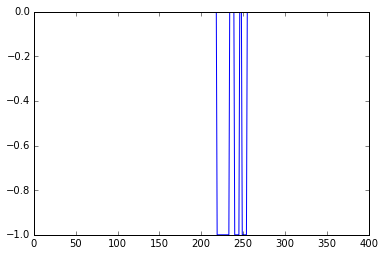

In [65]:
#vrep.simxStartSimulation(0, vrep.simx_opmode_oneshot_wait)
plt.plot(cam.image)

**Flashlight**

In [ ]:
class Flashlight(object):
    def __init__(self, string):
        self._brightness = 0
        self.handle = SimulatorObject.getFlashLight(string)
        LightSensor.FLASHLIGHTS_REGISTERED.append(self)

    @property
    def brightness(self):
        return self._brightness

    def brightness_pt(self, pt,cone_h=10., cone_r=10.):
        #do math
        trans = SimulatorObject.get_position(self.handle)
        euler_rots = SimulatorObject.get_euler_angles(self.handle)
        headmat = SimulatorObject._tf_matrix(trans, euler_rots)
        
        point0= headmat * np.matrix([[0, 0, 0, 1]]).T
        direction_vector = headmat * np.matrix([[1, 0, 0, 1]]).T - point0
        
        dummypos_vect = np.matrix([[pt[0], pt[1], pt[2], 1]]).T
       
        dist = np.dot(direction_vector.A1, dummypos_vect.A1)
        dist_vect = dist * direction_vector
        
        radius_at_point = (dist / cone_h) * cone_r
        
        rel_vect = dummypos_vect - point0
        to_get_distance = (rel_vect - dist_vect).A1
        ortho_dist = np.sqrt(np.dot(to_get_distance, to_get_distance))
        light = radius_at_point - ortho_dist
        return 0 if light <=0 else light

    @brightness.setter
    def brightness(self, value):
        self._brightness = value

**Light Sensor**

In [6]:
class LightSensor(object):
    FLASHLIGHTS_REGISTERED = []
    def __init__(self, string):
        self._light_value = 0
        self.handle = SimulatorObject.getLightSensor(string)

    @property
    def light_value(self):
        return sum([fl.brightness_pt(SimulatorObject.get_position(self.handle)) for fl in FLASHLIGHTS_REGISTERED])